In [ ]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy.linalg as la
import scipy.io
import sys

import sparsify
import utility

In [2]:
# Load video data from a npz file
mat = scipy.io.loadmat('./data/IMAGES_Vanhateren.mat')
vm = mat['IMAGES'].astype('float32')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
utility.imshow(vm[:, :, 7],ax=ax)

In [17]:
# Now let's start to learn sparse coding basis
# Effective dimensionality is about 200, let's make it 20 times overcomplete.
# Layer1 sparse coding initialization

xdim = 16 #Patch size
ydim = 16 #Patch size
BASIS1_NUM = 2048
BASIS1_SIZE = [xdim*ydim, BASIS1_NUM]
BATCH_SIZE = 100

basis1 = torch.randn(BASIS1_SIZE).cuda()
basis1 = basis1.div_(basis1.norm(2,0))

lambd = 1.0
STEPS = 3_000_000

ACT_HISTORY_LEN = 300
HessianDiag = torch.zeros(BASIS1_NUM).cuda()
ActL1 = torch.zeros(BASIS1_NUM).cuda()
signalEnergy = 0.
noiseEnergy = 0.

edgeBuff = 5
spRange_x = vm.shape[0] - xdim - edgeBuff * 2
spRange_y = vm.shape[1] - ydim - edgeBuff * 2
spRange_t = vm.shape[2]
I = np.zeros([xdim*ydim,BATCH_SIZE]).astype('float32')
totalSteps1 = 0

In [18]:
def ISTA_PN(I,basis,lambd,num_iter,eta=None, useMAGMA=True):
    # This is a positive-negative PyTorch-Ver ISTA solver
    # MAGMA uses CPU-GPU hybrid method to solve SVD problems, which is great for single task. When running multiple jobs, this flag should be turned off to leave the svd computation on only GPU.
    dtype = basis.type()
    batch_size=I.size(1)
    M = basis.size(1)
    if eta is None:
        if useMAGMA:
            L = torch.max(torch.linalg.eigvalsh(torch.mm(basis, basis.t()), UPLO='U'))
            eta = 1./L
        else:
            eta = 1./cp.linalg.eigvalsh(cp.asarray(torch.mm(basis,basis.t()).cpu().numpy())).max().get().reshape(1)
            eta = torch.from_numpy(eta.astype('float32')).cuda()

    #Res = torch.zeros(I.size()).type(dtype)
    #ahat = torch.zeros(M,batch_size).type(dtype)
    Res = torch.cuda.FloatTensor(I.size()).fill_(0)
    ahat = torch.cuda.FloatTensor(M,batch_size).fill_(0)

    for t in range(num_iter):
        ahat = ahat.add(eta * basis.t().mm(Res))
        ahat_sign = torch.sign(ahat)
        ahat.abs_()
        ahat.sub_(eta * lambd).clamp_(min = 0.)
        ahat.mul_(ahat_sign)
        Res = I - torch.mm(basis,ahat)
    return ahat, Res

In [27]:
for i in range(totalSteps1,STEPS):
    for j in range(BATCH_SIZE):
        xIdx = np.floor(np.random.rand()*spRange_x + edgeBuff).astype(int)
        yIdx = np.floor(np.random.rand()*spRange_y + edgeBuff).astype(int)
        sIdx = np.floor(np.random.rand()*spRange_t).astype(int)
        I[:,j] = vm[xIdx:xIdx+xdim,yIdx:yIdx+ydim,sIdx].reshape([xdim*ydim])
    I_cuda = torch.from_numpy(I).cuda()
    
    #Sparse Coefficients Inference by ISTA
    #For positive-only codes, use ISTA
    #For positive-negative codes, use ISTA_PN 
    ahat, Res = ISTA_PN(I_cuda, basis1, 0.08, 1000)
    #ahat, Res = sparsify.ISTA(I_cuda, basis1, 0.03, 1000)
    
    #Statistics Collection
    ActL1 = ActL1.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + ahat.abs().mean(1)/ACT_HISTORY_LEN
    HessianDiag = HessianDiag.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(ahat,2).mean(1)/ACT_HISTORY_LEN
    
    signalEnergy = signalEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(I_cuda,2).sum()/ACT_HISTORY_LEN
    noiseEnergy = noiseEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(Res,2).sum()/ACT_HISTORY_LEN
    snr = signalEnergy/noiseEnergy
    
    #Dictionary Update
    totalSteps1 = totalSteps1 + 1
    basis1 = sparsify.quadraticBasisUpdate(basis1, Res, ahat, 0.001, HessianDiag, 0.005)
    
    #Print Information
    if i % 100 == 0:
        print(f"step: {int(totalSteps1)} | S-N-R: {snr.item()} | "
              f"Hessian min: {HessianDiag.min()}, max: {HessianDiag.max()} | "
              f"Act min: {ActL1.min()}, max: {ActL1.max()}, sum: {ActL1.sum()}")

step: 95901 | S-N-R: 520.0992431640625 | Hessian min: 0.0027826314326375723, max: 0.0419267937541008 | Act min: 0.015654336661100388, max: 0.06255613267421722, sum: 60.562591552734375


KeyboardInterrupt: 

In [ ]:
import numpy as np


def construct_differential_operator(num_nodes, edges):
    # num_nodes: total number of nodes
    # edges: list of edges as pairs of neighbors (xi, xj)

    # Initialize a sparse matrix with lil_matrix
    D = lil_matrix((len(edges), num_nodes), dtype=np.int8)

    # Iterate through each edge and set the corresponding entries in the matrix
    for k, (xi, xj) in enumerate(edges):
        D[k, xi] = 1
        D[k, xj] = -1

    return D

# Example usage
num_nodes = 5
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]

D = construct_differential_operator(num_nodes, edges)

# Print the resulting matrix
print("Differential Operator D:")
print(D.toarray())

In [ ]:
def natural_nghb_matrix(A, scheme='spatial', spatial_range=3, spatial_weight = 1
                          temporal_range=2, temporal_causality=True, temporal_weight = 1):
    NB = torch.zeros_like(A[:2]) # initialize
    # set diagonal (i, i) to 1
    
    if scheme == 'temporal' or scheme == 'spatiotemporal':
        # assert data has sequence dimension
        # find the previous (and the next if temporal_causality=False) sequence elements for the patch
        # get them in ((x, y), weight->delta_t) format
        # if spatiotemporal multiply by temporal_weight
        # set (x, y) of NB
        
    if scheme == 'spatial' or scheme == 'spatiotemporal':
        # find the neighbouring pathces spatially
        # get them in ((x, y), distance) format
        # if spatiotemporal multiply by spatial_weight
        # set (x, y) of NB

In [ ]:
A = None
V = 1/N * (A * A.T) # covariance matrix of A
N = None # Total number of datapoints
D = natural_nghb_matrix(A, scheme="temporal") # Second-order differential operator, any clustering and neighbour search can be used

In [ ]:
# deterministic solution
# drawbacks:
#  - unnecessary ordering among different dimensions
#  - learned functional embedding tends to be global
#  - not online, does not allow other constraints

def get_trailing_eigenvectors(U):
    pass

U = torch.pow(V, 1/2) * A * D * D.T * A.T * torch.pow(V, 1/2)
U = get_trailing_eigenvectors(U)
P = torch.pow(V, 1/2) * U

In [29]:
# SGD solution
n_epochs = None # optimization steps
lr = None # learning rate
gama = None # weight of optimization objective
gamma_reg = None # weight of regularization
P = None # initialize

def shrinkage(A, P):
    # shrink each entry in the j-th column of P by gamma_reg * <a_j> 
    # a_j is the j-th column of A
    # <.> denotes inner product


for epoch in n_epochs:
    for A_batch in A:
        # whitened gradient computed on mini-batch
        P -= -2 * gamma * lr * P * A_batch * D * D.T * A_batch.T * 1/V
        P = shrinkage(A, P) # regularization
        P = torch.pow(P * V * P.T, -1/2) * P # orthogonalization      

SyntaxError: invalid syntax (<ipython-input-29-8984bdb2049e>, line 10)

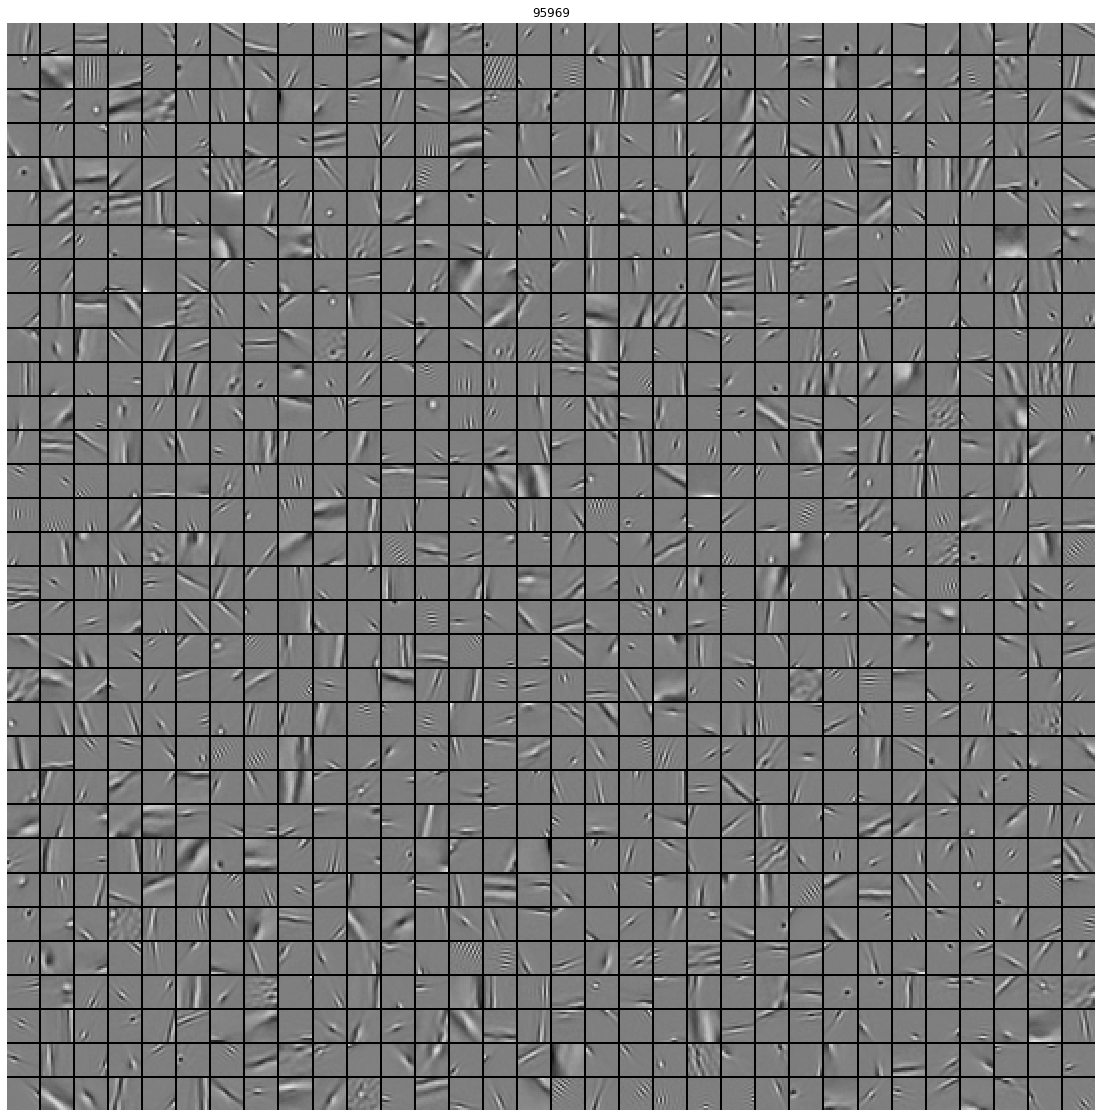

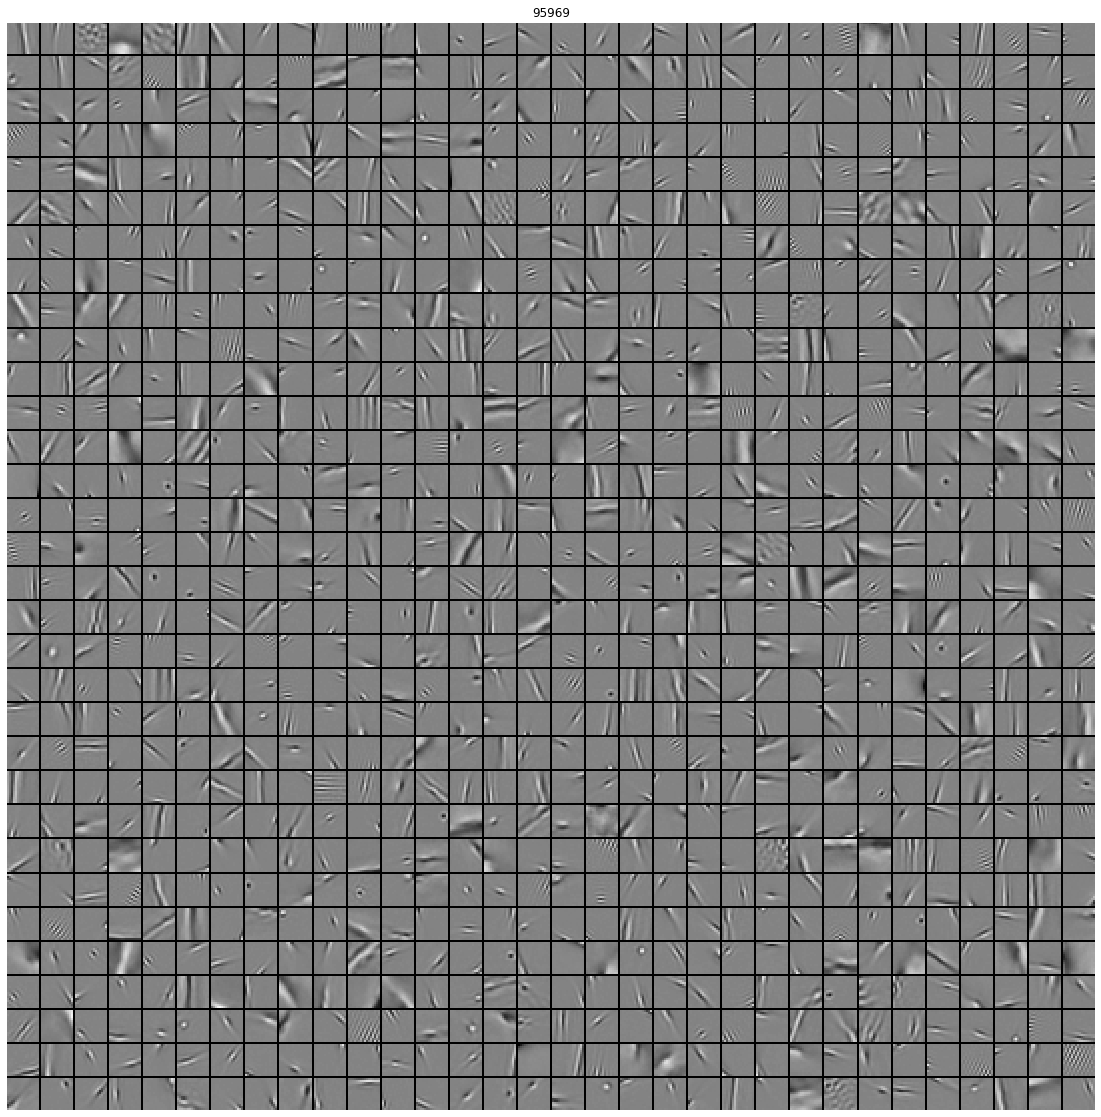

In [28]:
#Dictionary Visualization
basis1_host = basis1.cpu().numpy()
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
utility.displayVecArry(basis1_host,32,32,ax=ax,title=i,equal_contrast=True) #Visualize first 1024 Dictionary Elements
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
utility.displayVecArry(basis1_host[:,1024:],32,32,ax=ax,title=i,equal_contrast=True) #Visualize first 1024 Dictionary Elements

In [40]:
np.savez("basis1_IMAGES_Vanhateren_10x.npz", basis1 = basis1_host)